## This is set for python3

Structure of the analysis is as follows...

- We define up two rank based loss functions: these are functions of the predicted ranks of the 'active' molecules. The first only considers the rank of the highest ranked active, the second considers the average of all the ranks of the actives.
- We do standard 5-fold cross-validation and bootstrap cross-validation. Out of sample predictions are evaluated using the above active-rank loss functions and mean squared error.
- We progressively lower the threshold activity (in terms of the quantile of the activity distribution) and fit the models on a boostrapped datasets with only molecules that have activity beneath this threshold.
- We look at additive loss functions on which to train (penalize) the models better reflecting the out of sample loss.


## Inputs and main functions

In [1]:
from __future__ import division, print_function

import joblib
import numpy as np
from IPython.display import SVG
from scipy.spatial.distance import pdist, squareform, jaccard, cityblock
from scipy import stats

from multiprocessing import Pool
from copy import deepcopy

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model as LM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge, ElasticNet, Lasso

from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR

# Deep learning model with intermediate layer...
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(128, input_dim=128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))

# Model dictionaries 
model_labels = ['Ridge Regression','Random Forests','Support Vector Regression','Deep Learning']
model_dict = {'ridge' : {'m' : Ridge, 'kw' : {'fit_intercept':True, 'alpha':0.1}, 'label' : model_labels[0],},
              'rf'    : {'m' : RandomForestRegressor, 'kw' : {'n_estimators':100, 
                                                              'n_jobs':4, 'max_depth':10},  'label' : model_labels[1],},
              'svr'   : {'m' : SVR, 'kw' : {}, 'label' : model_labels[2],},
              
              'dl_l'   : {'m' : Pipeline, 
                          'kw' : {'steps': [('standardize', StandardScaler()),
                                            ('mlp', KerasRegressor(build_fn=larger_model, 
                                                                   epochs=100, batch_size=5, 
                                                                   verbose=0))
                                                           ]},  'label' : model_labels[3],
                         },
             }

# Datasets
from glob import glob
targets = [s.replace('datasets/', '') for s in glob('datasets/*')]

import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Runs without deep learning are much faster - this controls use of DL
do_dl = True
shuffle=False

In [4]:
# Arguments for overall number of runs
if not do_dl:
    # Take out when we want to run deep learning model
    del model_dict['dl_l']
    tot_num_runs = 800
    outdir = 'models_final/'
    fig_dir = 'figures/'
    ['svr', 'rf', 'ridge']
else:
    tot_num_runs = 400
    outdir = 'models_final_dl/'
    fig_dir = 'figures_dl/'

In [5]:
# Pull in data for a single target name
def get_data(tgt_name='COX-2'):
    data_dir = 'datasets/' + tgt_name + '/'
    preds = joblib.load(data_dir + tgt_name + '_predsu.npy')
    resps = joblib.load(data_dir + tgt_name + '_respu.npy')
    smiles = joblib.load(data_dir + tgt_name + '.smiu')
    dy = joblib.load(data_dir + tgt_name + '.dyu')
    return preds, resps, smiles, dy

In [6]:
# Write the loss functions 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def avg_mse(predictions, responses, **kwargs):
    return mean_squared_error(responses, predictions) / mean_squared_error(responses, np.zeros_like(responses))


def Rank_loss(predictions, responses, **kwargs):
    
    tgt_val = kwargs.get('tgt_val')
    ranked = np.argsort(-predictions)
    found = responses[ranked] >= tgt_val
    # Number of actives
    N_gamma = np.sum(found)
    
    # Size of test sets
    N_test = predictions.shape[0]
    lt = kwargs.get('loss_type')
    #pdb.set_trace()
    if lt == 'min':
        # Equation (1) of the paper
        loss = 1/(N_test - N_gamma) * np.min(np.arange(N_test)[found])
    elif lt == 'avg':
        # Equation (2) of the paper
        loss = 1/N_gamma * 1/(N_test - N_gamma) * (np.sum(np.arange(N_test)[found]) - N_gamma * (N_gamma - 1)/2)
        pass
    
    assert loss >= 0
    assert loss <= 1
    return loss


def Active_rank_loss_avg(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'avg'})
    return Rank_loss(predictions, responses, **kwargs)

def Active_rank_loss_min(predictions, responses, **kwargs):
    kwargs.update({'loss_type' :'min'})
    return Rank_loss(predictions, responses, **kwargs)


def nbs_run(kwargs):
    my_is = kwargs.get('is')
    my_oos = kwargs.get('oos')
    method = kwargs.get('method')
    preds = kwargs.get('preds') + 0.
    resps = kwargs.get('resps')
    
    mdl = model_dict[method]['m'](**model_dict[method]['kw'])
    mdl.fit(preds[my_is], resps[my_is])
        
    predictions = mdl.predict(preds[my_oos])
    
    losses = {}
    for (l, v) in loss_dict.items():
        
        # Worth noting, we're looking for the top frac_find _in_the_oos_data_
        # (not in the whole data - as otherwise we might be looking for something
        # that isn't there)
        if 'frac_find' in v['kw']:
            N = len(resps[my_oos])
            sorted_indices = np.argsort(resps[my_oos])
            n = int(N * v['kw']['frac_find'])
            tgt_val = resps[my_oos][sorted_indices[n]]
            v['kw'].update({'tgt_val' : tgt_val})
            
        losses[l] = v['func'](predictions, resps[my_oos], **v['kw'])
        pass
    
    return losses
    
    
def full_bootstrap(preds, resps, method, num_runs=100, insample=False,
                  frac_fit=1.0, num_kf=0, use_pool=True):

    # losses is going to be a list of dicts, loss_type => value
    losses = []
    
    sorted_indices = np.argsort(resps)

    N = len(resps)
    M = int(N * frac_fit)
    
    # Choose insample values...
    idx_list = []
    for i in range(num_runs):
        if num_kf > 0:
            kf = KFold(n_splits=num_kf, shuffle=True)
            for (tr_i, tst_i) in kf.split(np.arange(M)):
                idcs = sorted_indices[tr_i]
                pass
            pass
        else:
            idcs_rand = np.random.choice(M, M)
            idcs = sorted_indices[idcs_rand]
            pass
        idx_list.append({'is' : idcs})
        pass
    
    # Add in all the other data...
    for d in idx_list:
        if insample:
            oos = d['is']
        else:
            oos = np.delete(np.arange(N), d['is'])
            pass
        d.update({'oos' : oos, 'preds' : preds, 
                  'resps' : resps, 'method' : method})
        pass
            
    if use_pool:
        p = Pool(7)
        losses = p.map(nbs_run, idx_list)
        p.close()
        p.join()
    else:
        losses = [nbs_run(x) for x in idx_list]
        pass
    return losses

In [7]:
# Unit tests for the loss functions...
responses = np.arange(10)
tgt_val = 8

# get it totally right
predictions = np.arange(10)

print('All correct')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('Active rank min', Active_rank_loss_min(predictions, responses, tgt_val=tgt_val))
print('Active rank avg', Active_rank_loss_avg(predictions, responses, tgt_val=tgt_val))

# get it totally right where it counts, but maximally wrong elsewhere
#predictions = np.asarray([0])

# one totally right, one totally wrong
predictions = np.roll(np.arange(10),-1)
print('\nOne right, one very wrong')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('Active rank min', Active_rank_loss_min(predictions, responses, tgt_val=tgt_val))
print('Active rank avg', Active_rank_loss_avg(predictions, responses, tgt_val=tgt_val))


# get everything wrong
predictions = np.arange(10)[::-1]
print('\nAll wrong')
print('r2', avg_mse(predictions, responses, tgt_val=tgt_val))
print('Active rank min', Active_rank_loss_min(predictions, responses, tgt_val=tgt_val))
print('Active rank avg', Active_rank_loss_avg(predictions, responses, tgt_val=tgt_val))
# 

All correct
r2 0.0
Active rank min 0.0
Active rank avg 0.0

One right, one very wrong
r2 0.315789473684
Active rank min 0.0
Active rank avg 0.5

All wrong
r2 1.15789473684
Active rank min 1.0
Active rank avg 1.0


In [8]:
def summarize(results):
    summary = {}
    for l in loss_dict.keys():
        vals = np.asarray([x[l] for x in results])
        if len(vals) == 1:
            summary[l] = {'loss' : vals[0]}
        else:
            summary[l] = {'loss_l' : np.percentile(vals, 5),
                          'loss' : np.mean(vals),                          
                          'loss_u' : np.percentile(vals, 95),
                         }
            pass
        pass
    return summary

In [9]:
# This function takes the vector of observed values and their mean (implies fewer computations of the mean)
def jackknife(vals, vals_bar):
    n = len(vals)
    var_JK = 0.0
    for v in vals:
        vals_bar_i = (n/(n-1)) * (vals_bar - v/n)
        #print(pow(vals_bar_i - vals_bar, 2))
        var_JK += pow(vals_bar_i - vals_bar, 2)
        pass

    sd_JK = pow( ((n-1)/n) * var_JK, .5)
   
    return sd_JK
    
def jackknife_summary(results):
    summary = {}
    for l in loss_dict.keys():
        vals = np.asarray([x[l] for x in results])
        if len(vals) == 1:
            summary[l] = {'loss' : vals[0]}
        else:
            vals_bar = np.mean(vals)
            sd = jackknife(vals, vals_bar)
            summary[l] = {'loss_l' : vals_bar - 2*sd,
                          'loss' : vals_bar,                          
                          'loss_u' : vals_bar + 2*sd,
                         }
            pass
        pass
    return summary

In [10]:
sorted_targets = sorted(targets, key=lambda x: len(get_data(x)[0]))

In [11]:
import os.path
import re

# define the dictionary of losses used here
loss_dict = {'mse' :       {'func' : avg_mse,         'kw' : {}},
             'loss_min_90' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.9}},
             'loss_avg_90' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.9}},
             'loss_min_95' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.95}},
             'loss_avg_95' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.95}},
             'loss_min_99' :   {'func' : Active_rank_loss_min,  'kw' : {'frac_find' : 0.99}},
             'loss_avg_99' :   {'func' : Active_rank_loss_avg,  'kw' : {'frac_find' : 0.99}},
                           }
def get_fn(frac_fit, kf=0, insample=False, fig=False, loss=None):
    fn = 'loss_' + str(frac_fit)
    if kf > 0:
        fn += '_kf_' + str(kf)
        pass
    if insample:
        fn += '_insample'
        pass
    od = fig_dir if fig else outdir
    ffn = os.path.join(od, fn)
    if fig:
        ffn = re.sub('[.]','', ffn)
        ffn = ffn + '_' + loss + '.pdf'
        pass
    return ffn
        

def runner(frac_fit=1.0, kf=0, insample=False, use_pool=True):

    fnf = get_fn(frac_fit, kf=kf, insample=insample)
    if os.path.isfile(fnf) and not force_rerun:
        print('Already computed')
        return

    loss_hdr = {}
    if insample:
        num_runs = 1
    elif kf > 0:
        num_runs = int(tot_num_runs/kf)
    else:
        num_runs = tot_num_runs
    
    for tgt in sorted_targets:
        loss_hdr[tgt] = {}
        print ('Doing', tgt)
        preds, resps, _, dy = get_data(tgt)
        preds = preds + 0.
        for m in model_dict.keys():
            res = full_bootstrap(preds, resps, m, frac_fit=frac_fit, num_kf=kf,
                                 insample=insample, num_runs=num_runs, use_pool=use_pool, 
                                )
            joblib.dump(res, outdir + '/detail/' + tgt + '_' + m + '_' + str(frac_fit) + '_' + str(kf) + '.res')
            loss_hdr[tgt][m] = jackknife_summary(res)
        pass
    joblib.dump(loss_hdr, fnf)
    print('Completed')
    return

In [12]:
import matplotlib.pyplot as plt
%pylab inline
figsize(20, 10)
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
force_rerun = True

In [14]:
# insample run...
runner(insample=True)

Doing A2a
Doing Dopamine
Doing Dihydrofolate
Doing Carbonic
Doing ABL1
Doing opioid
Doing Cannabinoid
Doing Androgen
Doing COX-1
Doing Monoamine
Doing LCK
Doing Glucocortic
Doing Ephrin
Doing Caspase
Doing Coagulation
Doing Estrogen
Doing B-raf
Doing Glycogen
Doing Vanilloid
Doing Aurora-A
Doing JAK2
Doing COX-2
Doing Acetylcholin
Doing erbB1
Doing HERG
Completed


In [15]:
# Full OOS run...
runner()

Doing A2a
Doing Dopamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113080). Check your callbacks.
  % delta_t_median)


Doing Dihydrofolate
Doing Carbonic
Doing ABL1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111005). Check your callbacks.
  % delta_t_median)


Doing opioid
Doing Cannabinoid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123778). Check your callbacks.
  % delta_t_median)


Doing Androgen
Doing COX-1
Doing Monoamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110110). Check your callbacks.
  % delta_t_median)


Doing LCK
Doing Glucocortic
Doing Ephrin


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112907). Check your callbacks.
  % delta_t_median)


Doing Caspase


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129875). Check your callbacks.
  % delta_t_median)


Doing Coagulation


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123292). Check your callbacks.
  % delta_t_median)


Doing Estrogen
Doing B-raf


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102005). Check your callbacks.
  % delta_t_median)


Doing Glycogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126031). Check your callbacks.
  % delta_t_median)


Doing Vanilloid
Doing Aurora-A


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123201). Check your callbacks.
  % delta_t_median)


Doing JAK2


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125110). Check your callbacks.
  % delta_t_median)


Doing COX-2
Doing Acetylcholin
Doing erbB1
Doing HERG


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125126). Check your callbacks.
  % delta_t_median)


Completed


In [16]:
# OOS run with 5-fold CV for comparison
runner(kf=5)

Doing A2a


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129682). Check your callbacks.
  % delta_t_median)


Doing Dopamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125052). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128959). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124065). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123581). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103958). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.

Doing Dihydrofolate


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124104). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125477). Check your callbacks.
  % delta_t_median)


Doing Carbonic
Doing ABL1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125665). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124845). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127541). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117919). Check your callbacks.
  % delta_t_median)


Doing opioid
Doing Cannabinoid
Doing Androgen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114907). Check your callbacks.
  % delta_t_median)


Doing COX-1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123971). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109614). Check your callbacks.
  % delta_t_median)


Doing Monoamine
Doing LCK
Doing Glucocortic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120107). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122365). Check your callbacks.
  % delta_t_median)


Doing Ephrin
Doing Caspase
Doing Coagulation
Doing Estrogen
Doing B-raf
Doing Glycogen
Doing Vanilloid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123535). Check your callbacks.
  % delta_t_median)


Doing Aurora-A


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125222). Check your callbacks.
  % delta_t_median)


Doing JAK2
Doing COX-2
Doing Acetylcholin
Doing erbB1
Doing HERG
Completed


In [17]:
# OOS - max activity at 0.9
runner(frac_fit=0.9)

Doing A2a
Doing Dopamine
Doing Dihydrofolate


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106335). Check your callbacks.
  % delta_t_median)


Doing Carbonic
Doing ABL1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115761). Check your callbacks.
  % delta_t_median)


Doing opioid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125047). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130187). Check your callbacks.
  % delta_t_median)


Doing Cannabinoid
Doing Androgen
Doing COX-1
Doing Monoamine
Doing LCK
Doing Glucocortic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125319). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127463). Check your callbacks.
  % delta_t_median)


Doing Ephrin
Doing Caspase
Doing Coagulation


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124790). Check your callbacks.
  % delta_t_median)


Doing Estrogen
Doing B-raf
Doing Glycogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100354). Check your callbacks.
  % delta_t_median)


Doing Vanilloid
Doing Aurora-A
Doing JAK2
Doing COX-2
Doing Acetylcholin
Doing erbB1
Doing HERG


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147945). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129645). Check your callbacks.
  % delta_t_median)


Completed


In [18]:
# OOS - max activity at 0.8
runner(frac_fit=0.8)

Doing A2a


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122815). Check your callbacks.
  % delta_t_median)


Doing Dopamine
Doing Dihydrofolate
Doing Carbonic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125207). Check your callbacks.
  % delta_t_median)


Doing ABL1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102501). Check your callbacks.
  % delta_t_median)


Doing opioid
Doing Cannabinoid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126946). Check your callbacks.
  % delta_t_median)


Doing Androgen
Doing COX-1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120492). Check your callbacks.
  % delta_t_median)


Doing Monoamine
Doing LCK


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122181). Check your callbacks.
  % delta_t_median)


Doing Glucocortic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119862). Check your callbacks.
  % delta_t_median)


Doing Ephrin
Doing Caspase


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123451). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121358). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124001). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122383). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123205). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.

Doing Coagulation


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124773). Check your callbacks.
  % delta_t_median)


Doing Estrogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118638). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100396). Check your callbacks.
  % delta_t_median)


Doing B-raf


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120675). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119301). Check your callbacks.
  % delta_t_median)


Doing Glycogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124918). Check your callbacks.
  % delta_t_median)


Doing Vanilloid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107503). Check your callbacks.
  % delta_t_median)


Doing Aurora-A
Doing JAK2
Doing COX-2


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125106). Check your callbacks.
  % delta_t_median)


Doing Acetylcholin


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122607). Check your callbacks.
  % delta_t_median)


Doing erbB1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123447). Check your callbacks.
  % delta_t_median)


Doing HERG
Completed


In [19]:
# OOS - max activity at 0.6
runner(frac_fit=0.6)

Doing A2a


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125152). Check your callbacks.
  % delta_t_median)


Doing Dopamine
Doing Dihydrofolate


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125254). Check your callbacks.
  % delta_t_median)


Doing Carbonic
Doing ABL1
Doing opioid
Doing Cannabinoid
Doing Androgen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124268). Check your callbacks.
  % delta_t_median)


Doing COX-1


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124987). Check your callbacks.
  % delta_t_median)


Doing Monoamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123454). Check your callbacks.
  % delta_t_median)


Doing LCK
Doing Glucocortic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106409). Check your callbacks.
  % delta_t_median)


Doing Ephrin


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113961). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126769). Check your callbacks.
  % delta_t_median)


Doing Caspase
Doing Coagulation


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117534). Check your callbacks.
  % delta_t_median)


Doing Estrogen
Doing B-raf


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123709). Check your callbacks.
  % delta_t_median)


Doing Glycogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123758). Check your callbacks.
  % delta_t_median)


Doing Vanilloid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125027). Check your callbacks.
  % delta_t_median)


Doing Aurora-A


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131105). Check your callbacks.
  % delta_t_median)


Doing JAK2
Doing COX-2
Doing Acetylcholin
Doing erbB1
Doing HERG


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114415). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102483). Check your callbacks.
  % delta_t_median)


Completed


In [20]:
# OOS - max activity at 0.4
runner(frac_fit=0.4)

Doing A2a
Doing Dopamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124060). Check your callbacks.
  % delta_t_median)


Doing Dihydrofolate


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123397). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103949). Check your callbacks.
  % delta_t_median)


Doing Carbonic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124100). Check your callbacks.
  % delta_t_median)


Doing ABL1
Doing opioid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113354). Check your callbacks.
  % delta_t_median)


Doing Cannabinoid
Doing Androgen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123423). Check your callbacks.
  % delta_t_median)


Doing COX-1
Doing Monoamine


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125803). Check your callbacks.
  % delta_t_median)


Doing LCK


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125158). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126418). Check your callbacks.
  % delta_t_median)


Doing Glucocortic


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125351). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122967). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125558). Check your callbacks.
  % delta_t_median)


Doing Ephrin
Doing Caspase


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124163). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125357). Check your callbacks.
  % delta_t_median)


Doing Coagulation


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119761). Check your callbacks.
  % delta_t_median)


Doing Estrogen


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120751). Check your callbacks.
  % delta_t_median)


Doing B-raf


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130920). Check your callbacks.
  % delta_t_median)


Doing Glycogen
Doing Vanilloid


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103014). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122345). Check your callbacks.
  % delta_t_median)


Doing Aurora-A


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126465). Check your callbacks.
  % delta_t_median)
/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132134). Check your callbacks.
  % delta_t_median)


Doing JAK2
Doing COX-2


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125516). Check your callbacks.
  % delta_t_median)


Doing Acetylcholin


/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121168). Check your callbacks.
  % delta_t_median)


Doing erbB1
Doing HERG
Completed


In [22]:
# Plots results
# Added put_title arg for plots for paper
def plotter(frac_fit=1.0, kf=0, insample=False, loss='mse', save=True, put_title=False, put_grid=False):
    
    fnf = get_fn(frac_fit, kf=kf, insample=insample)
    
    loss_hdr = joblib.load(fnf)
    model_labels = []
    
    for (i, method) in enumerate(model_dict.keys()):
        model_labels.append(model_dict[method]['label'])
        losses = []
        for x in sorted_targets:
            try:
                losses.append(loss_hdr[x][method][loss]['loss'])
            except:
                print(x, method, loss)
                raise KeyError
        losses = np.asarray(losses)
        if insample:
            plot(np.arange(25) + 0.05*i, losses,  label=method.upper())
        else:
            loss_l = np.asarray([loss_hdr[x][method][loss]['loss_l'] for x in sorted_targets])
            loss_u = np.asarray([loss_hdr[x][method][loss]['loss_u'] for x in sorted_targets])
            
            yerr = np.vstack((losses - loss_l, loss_u - losses))
            
            errorbar(np.arange(25)+i*0.1, losses, capsize=10, yerr=yerr, label=method.upper())
            pass
        pass
        
    if insample:
        if put_title:
            title('Insample %s Loss' % loss.upper())
    else:
        ttl = 'OOS %s Loss' % loss.upper()
        if kf > 0:
            ttl += ' with %d fold CV' % kf
        if frac_fit < 1.0:
            ttl += ' Max activity in fit at %.1f' % frac_fit
        if put_title:
            title(ttl)
    pass

    grid(put_grid)
    plt.tick_params(top=False, right=False)
    plt.xticks(np.arange(25), sorted_targets, rotation=-45)
    plt.legend(loc='best', fontsize = 'x-large', labels=model_labels)
    if loss=='mse':
        plt.ylabel('Expected mean squared error', fontsize='x-large')
    else:
        plt.ylabel('Expected loss', fontsize='x-large')
    
    if save:
        fnff = get_fn(frac_fit, kf=kf, insample=insample, fig=True, loss=loss)
        print(fnff)
        savefig(fnff, bbox_inches='tight')

In [21]:
fnf = get_fn(frac_fit=1.0, kf=0, insample=False)
fnf
#loss_hdr = joblib.load(fnf)
#loss_hdr

'models_final_dl/loss_1.0'

### In-sample loss plots

In [ ]:
plotter(frac_fit=0.4)

figures_dl/loss_10_insample_mse.pdf


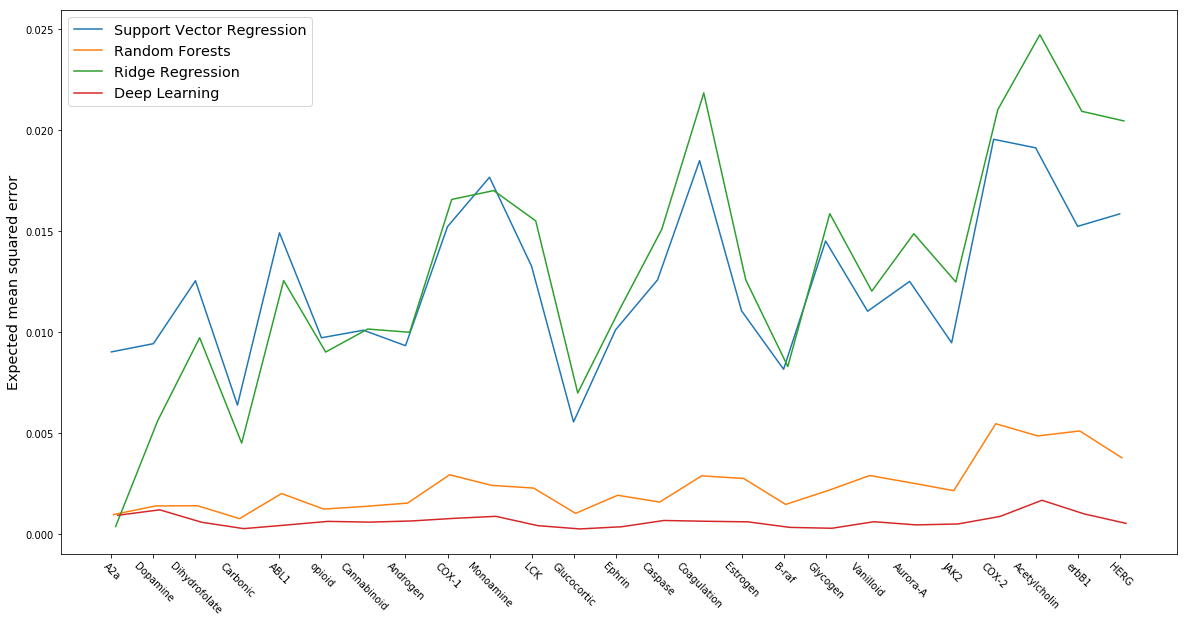

In [24]:
# We plot the in-sample MSE loss
plotter(insample=True)

figures_dl/loss_10_insample_loss_min_90.pdf


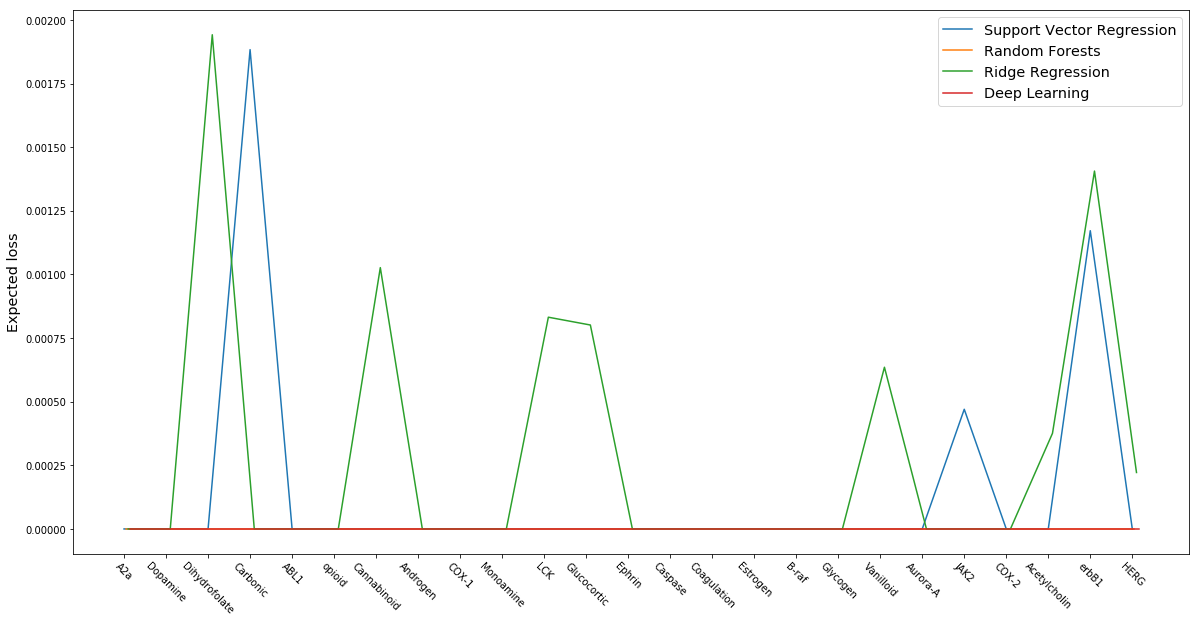

In [25]:
# We plot the in-sample active-rank min loss, with gamma = 0.9
plotter(insample=True, loss='loss_min_90')

figures_dl/loss_10_insample_loss_min_99.pdf


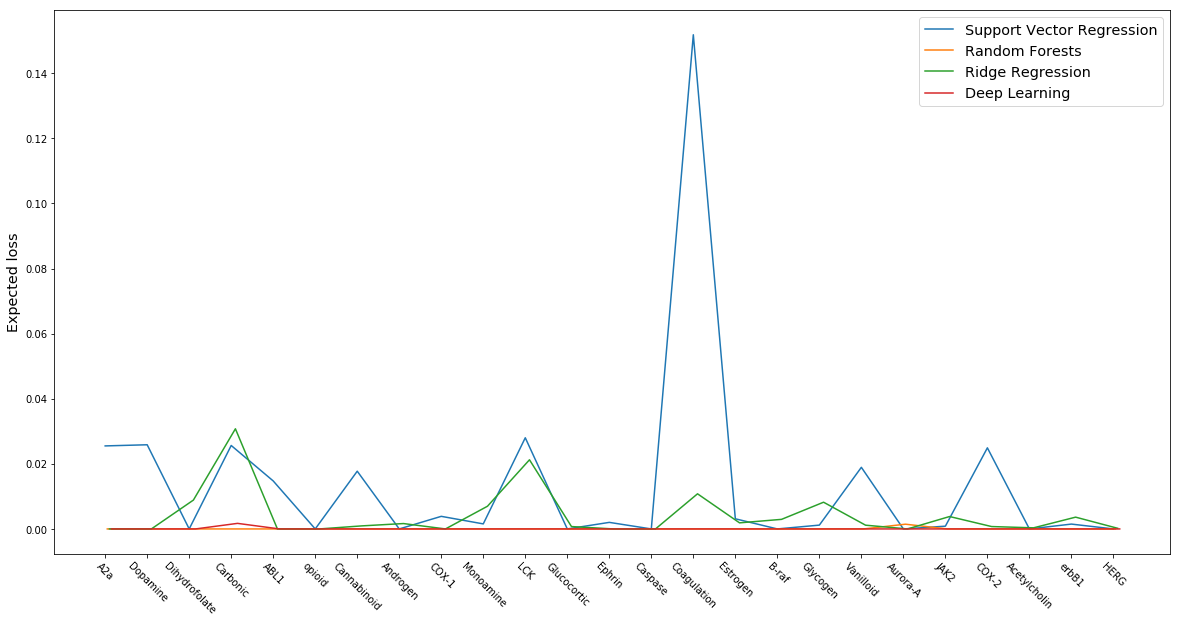

In [26]:
# We plot the in-sample active-rank min loss, with gamma = 0.99
plotter(insample=True, loss='loss_min_99')

figures_dl/loss_10_insample_loss_avg_90.pdf


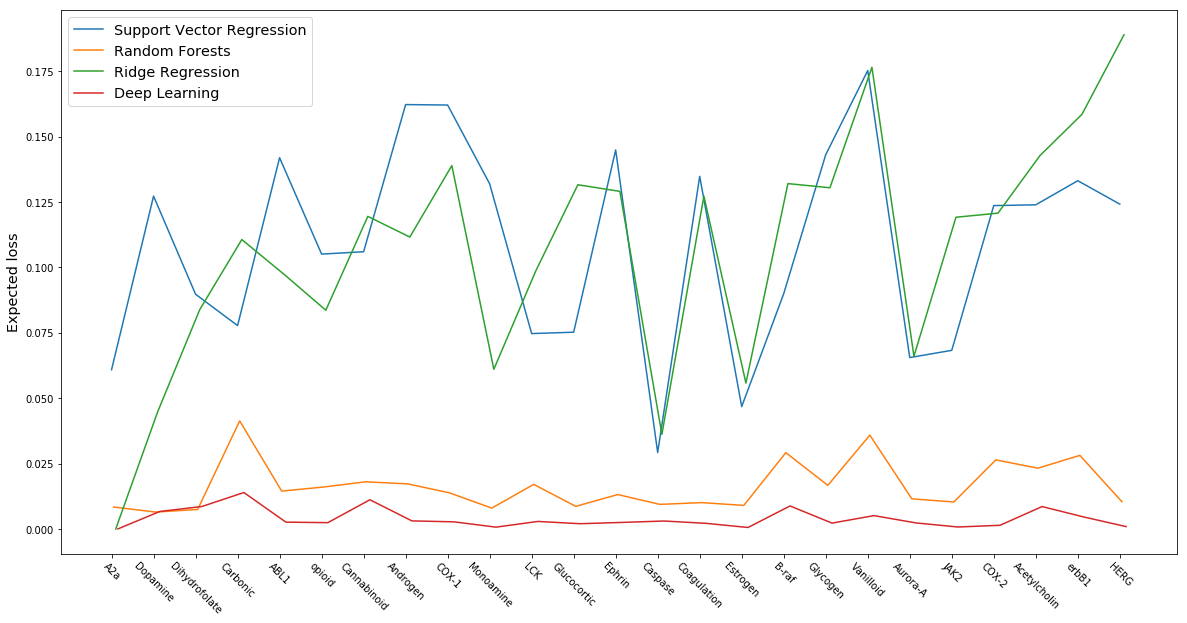

In [27]:
# We plot the in-sample active-rank average loss, with gamma = 0.9
plotter(insample=True, loss='loss_avg_90')

### Out-of-sample (random partitioning) loss plots (using CV)

figures_dl/loss_10_kf_5_mse.pdf


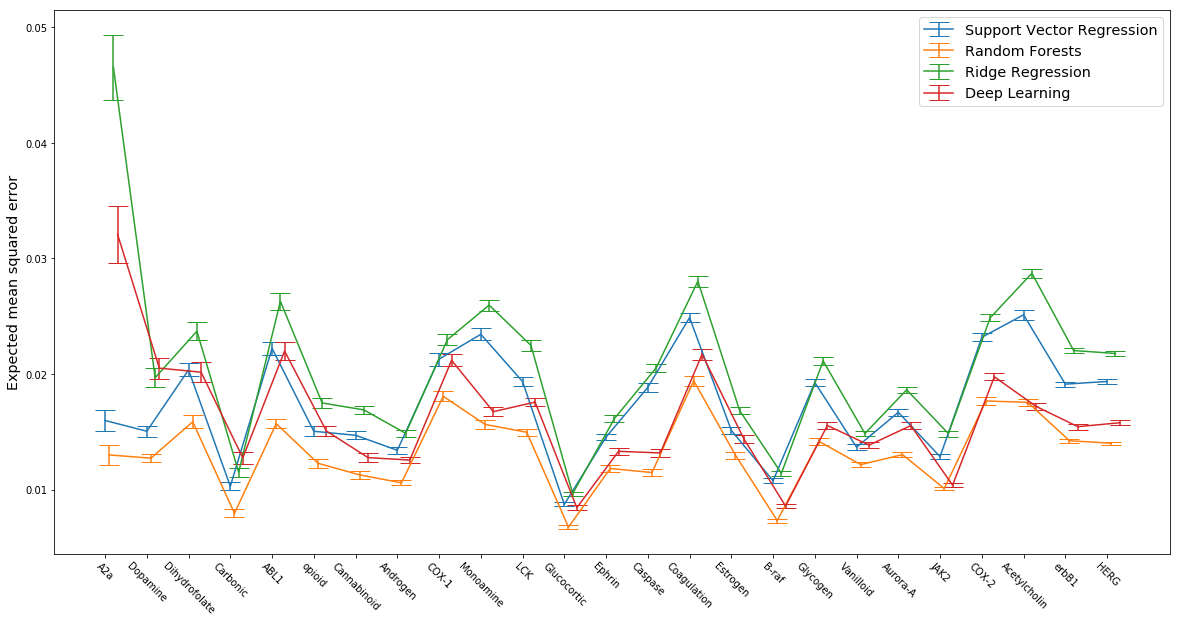

In [28]:
# 5-fold CV, scored by MSE
plotter(kf=5)

figures_dl/loss_10_kf_5_loss_avg_90.pdf


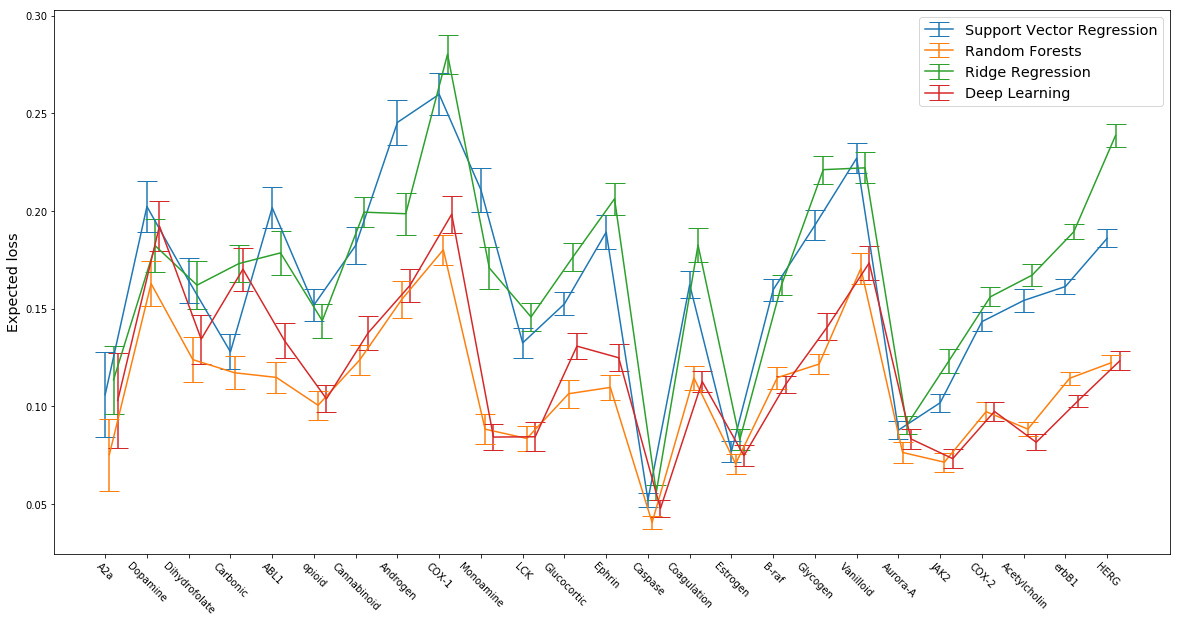

In [29]:
# 5-fold CV, scored by active-rank average loss, gamma = 0.9
plotter(kf=5, loss='loss_avg_90')

### Out-of-sample (random partitioning) loss plots (bootstrap)

figures_dl/loss_10_mse.pdf


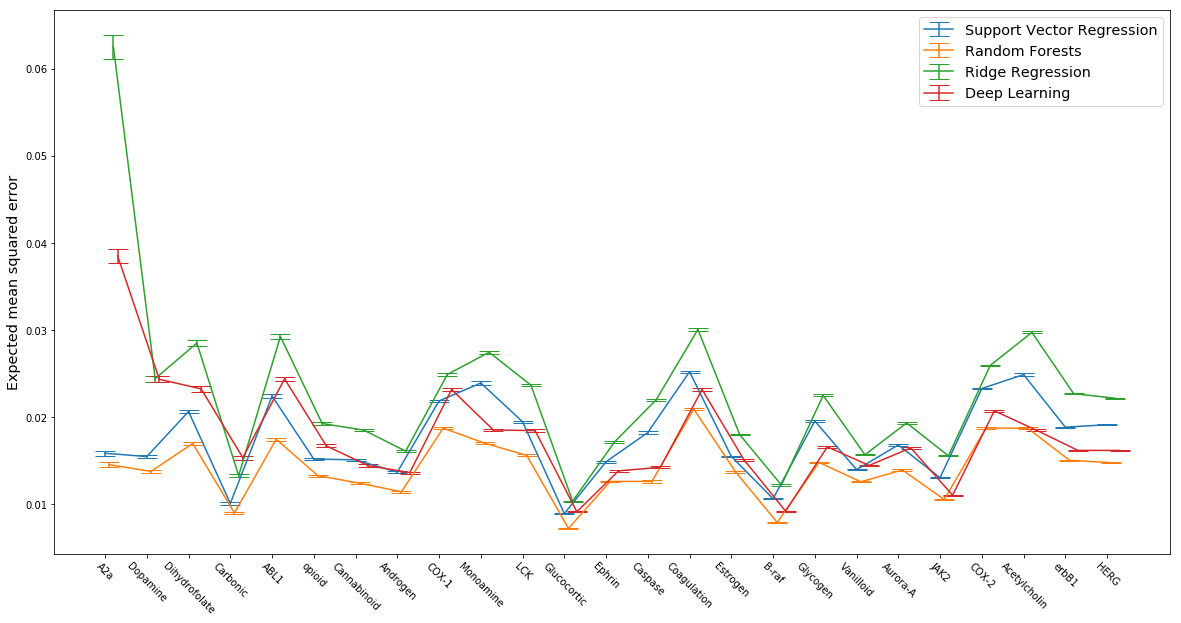

In [30]:
# bootstrap CV, scored by MSE
plotter()

figures_dl/loss_10_loss_avg_99.pdf


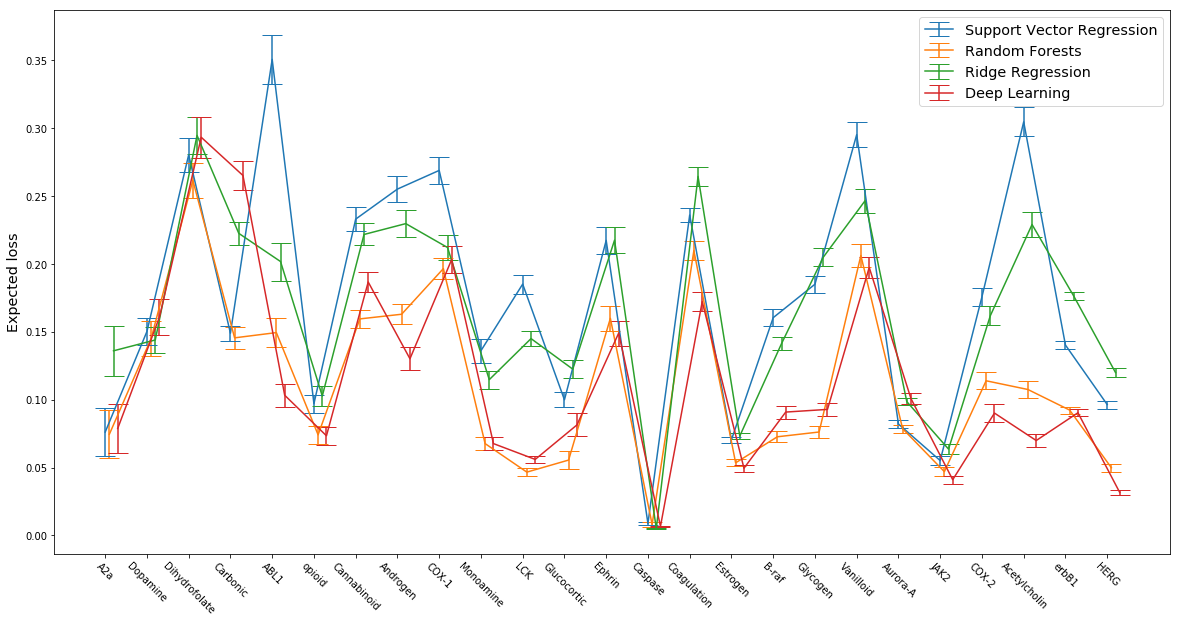

In [31]:
# bootstrap CV, scored by active-rank average loss, gamma = 0.9
plotter(loss='loss_avg_99')

figures_dl/loss_10_loss_min_90.pdf


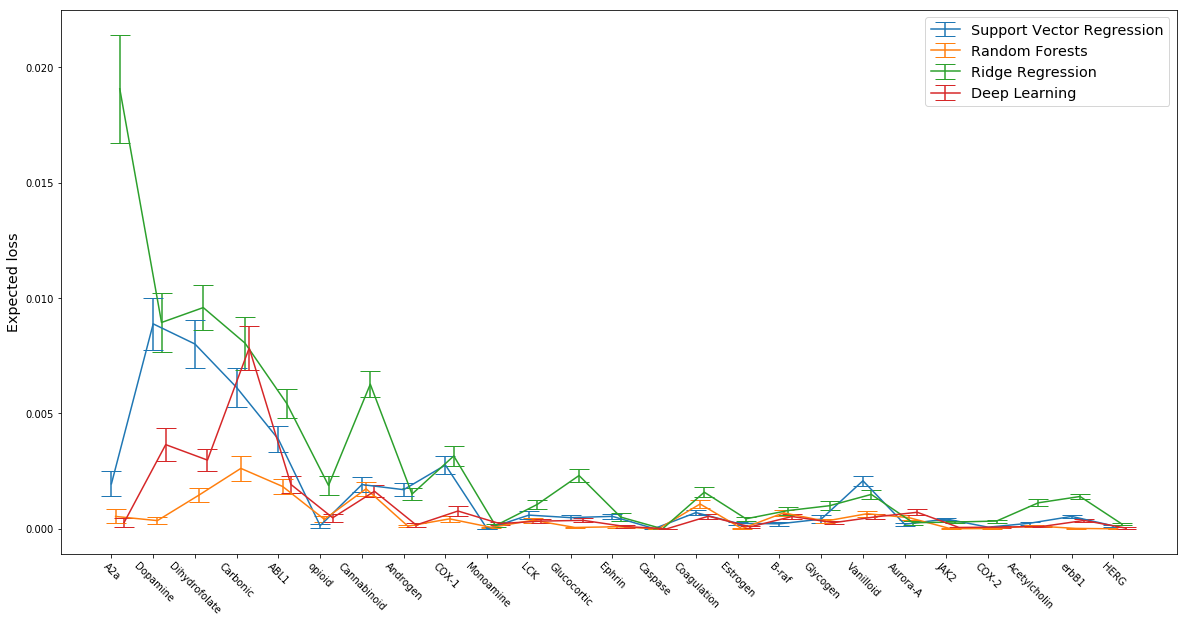

In [32]:
# bootstrap CV, scored by active-rank min loss, gamma = 0.9
plotter(loss='loss_min_90')

### Out-of-sample loss plots ( training on thresholded data: q=0.9 )

figures_dl/loss_09_mse.pdf


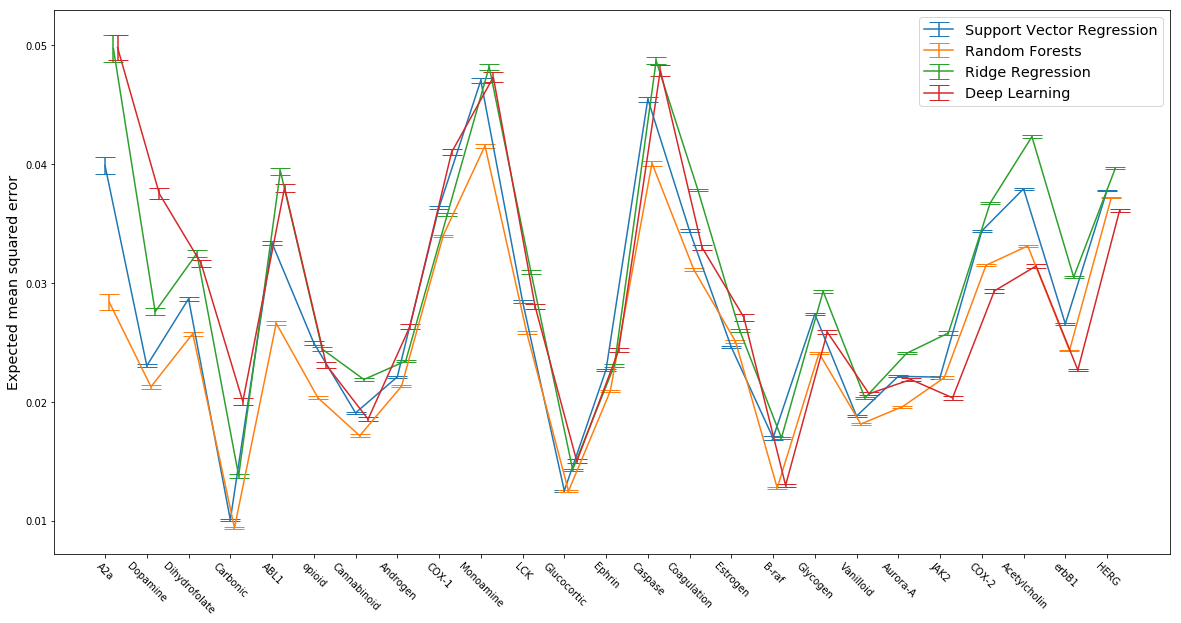

In [33]:
# Training set activity thresholded at q=0.9, scored by MSE
plotter(frac_fit=0.9)

figures_dl/loss_09_loss_avg_90.pdf


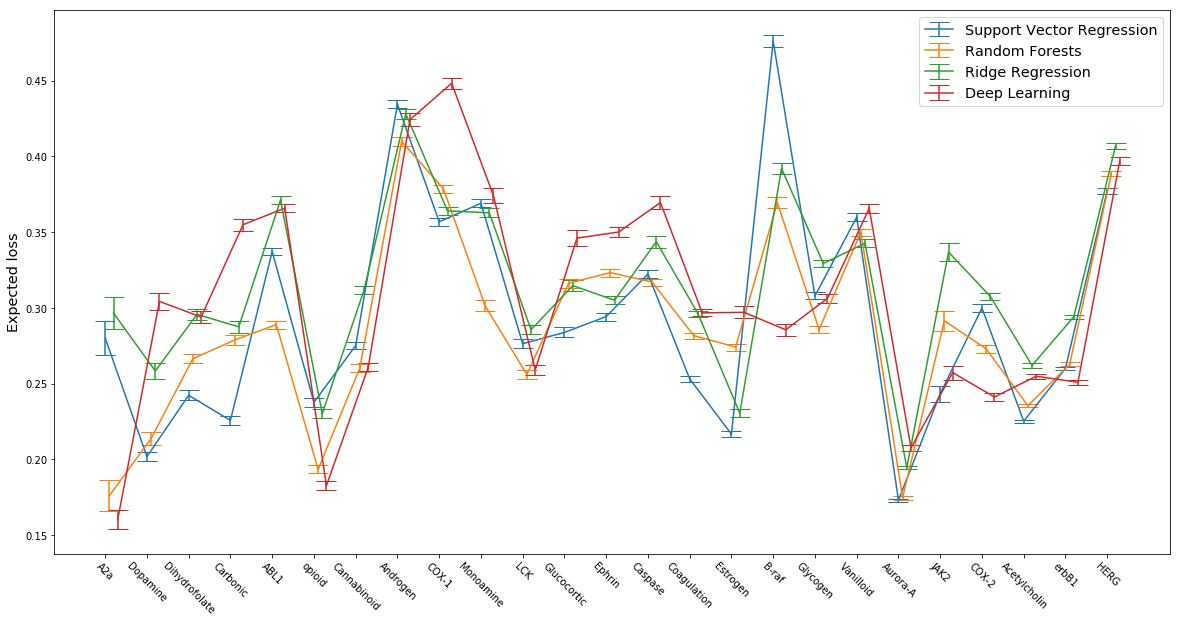

In [34]:
# Training set activity thresholded at q=0.9, scored by active-rank average loss, gamma = 0.9
plotter(frac_fit=0.9, loss='loss_avg_90')

figures_dl/loss_09_loss_min_90.pdf


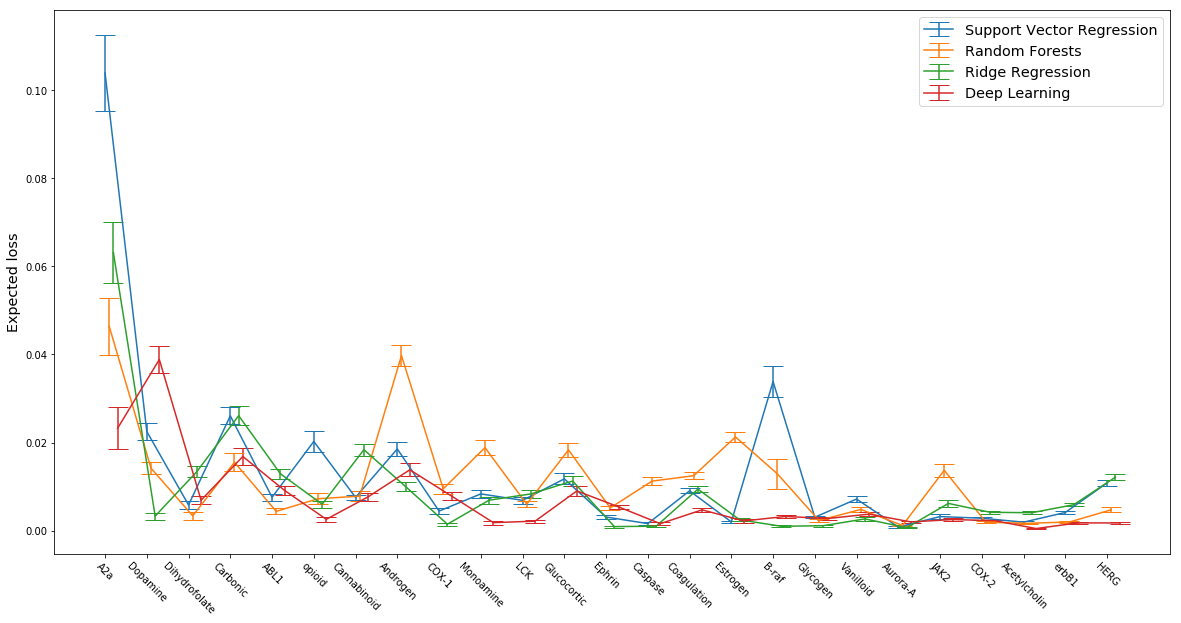

In [35]:
# Training set activity thresholded at q=0.9, scored by active-rank min loss, gamma = 0.9
plotter(frac_fit=0.9, loss='loss_min_90')

### Out-of-sample loss plots ( training on thresholded data: q=0.8 )

figures_dl/loss_08_mse.pdf


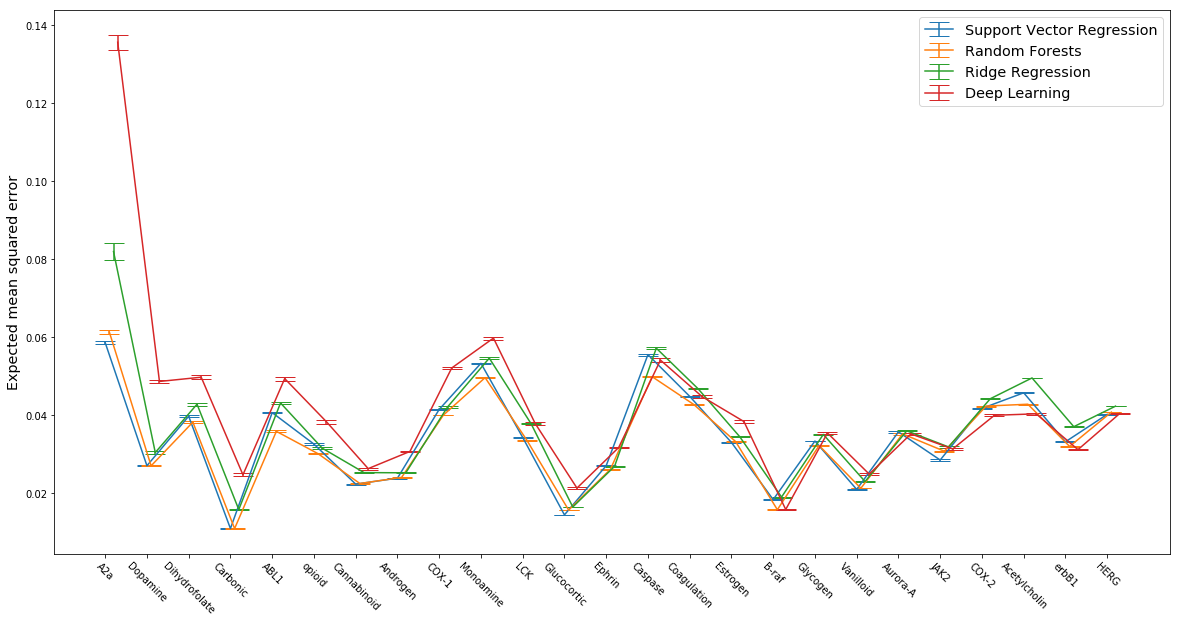

In [36]:
# Training set activity thresholded at q=0.8, scored by MSE
plotter(frac_fit=0.8)

figures_dl/loss_08_loss_avg_90.pdf


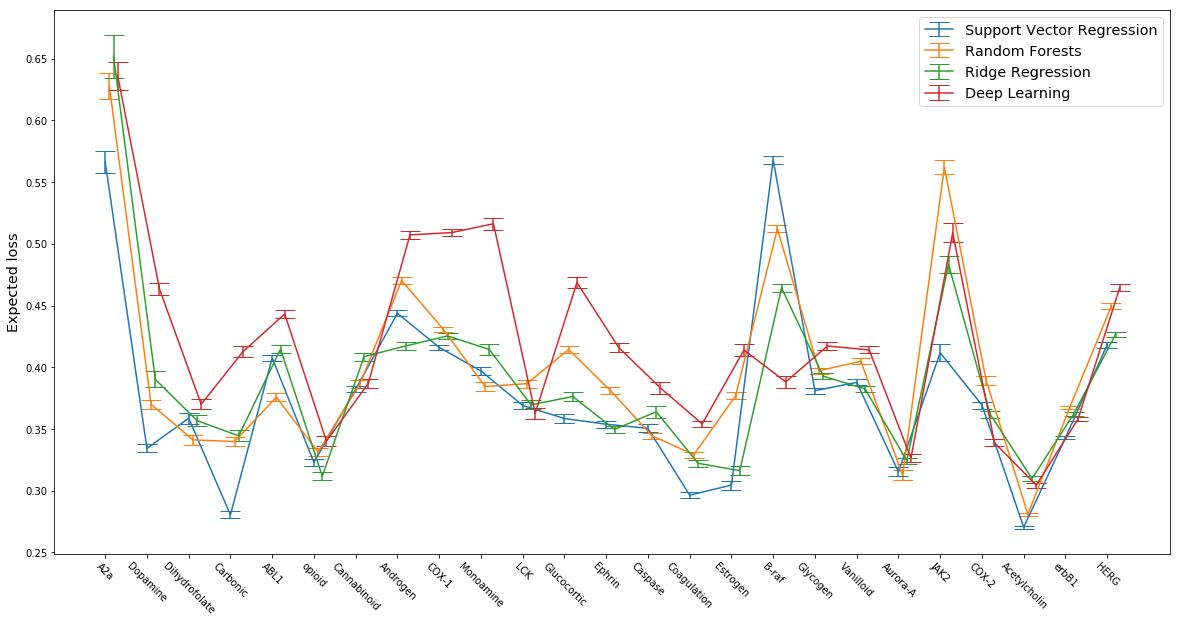

In [37]:
# Training set activity thresholded at q=0.8, scored by active-rank average loss, gamma = 0.9
plotter(frac_fit=0.8, loss='loss_avg_90')

figures_dl/loss_08_loss_min_90.pdf


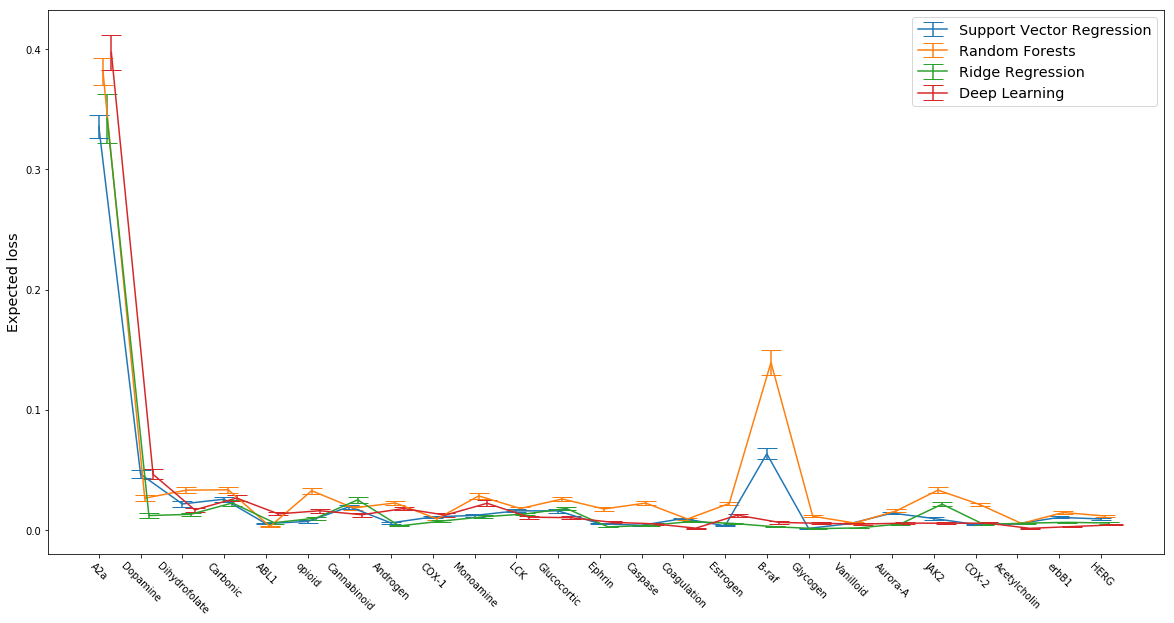

In [38]:
# Training set activity thresholded at q=0.8, scored by active-rank min loss, gamma = 0.9
plotter(frac_fit=0.8, loss='loss_min_90')

### Out-of-sample loss plots ( training on thresholded data: q=0.6 )

figures_dl/loss_06_mse.pdf


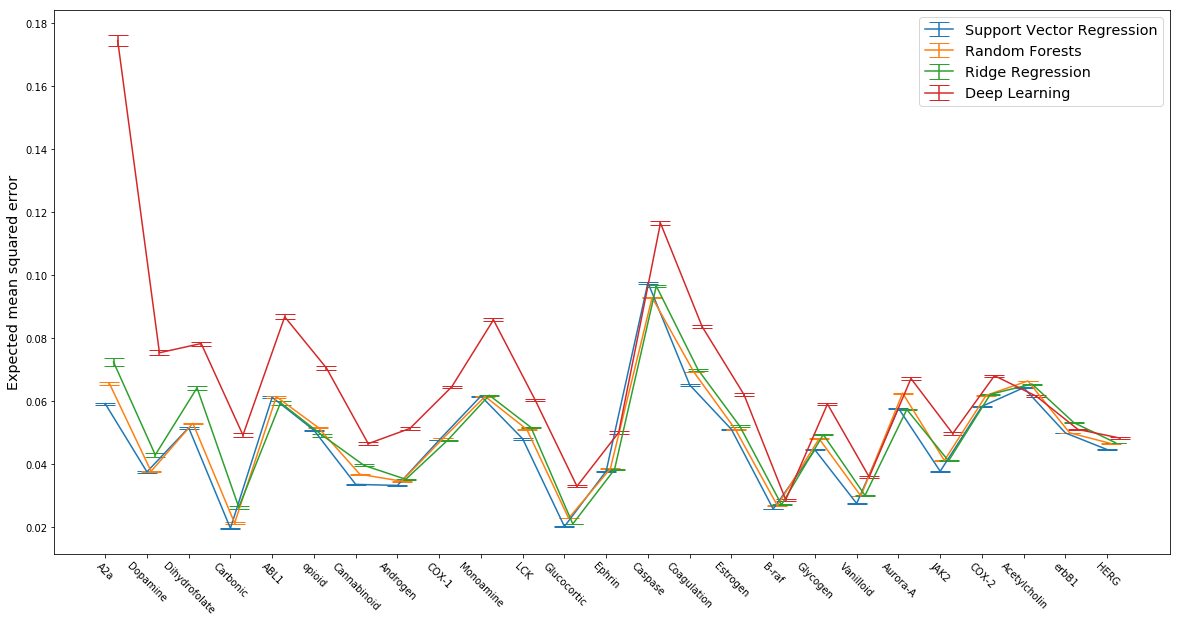

In [39]:
# Training set activity thresholded at q=0.6, scored by MSE
plotter(frac_fit=0.6)

figures_dl/loss_06_loss_avg_90.pdf


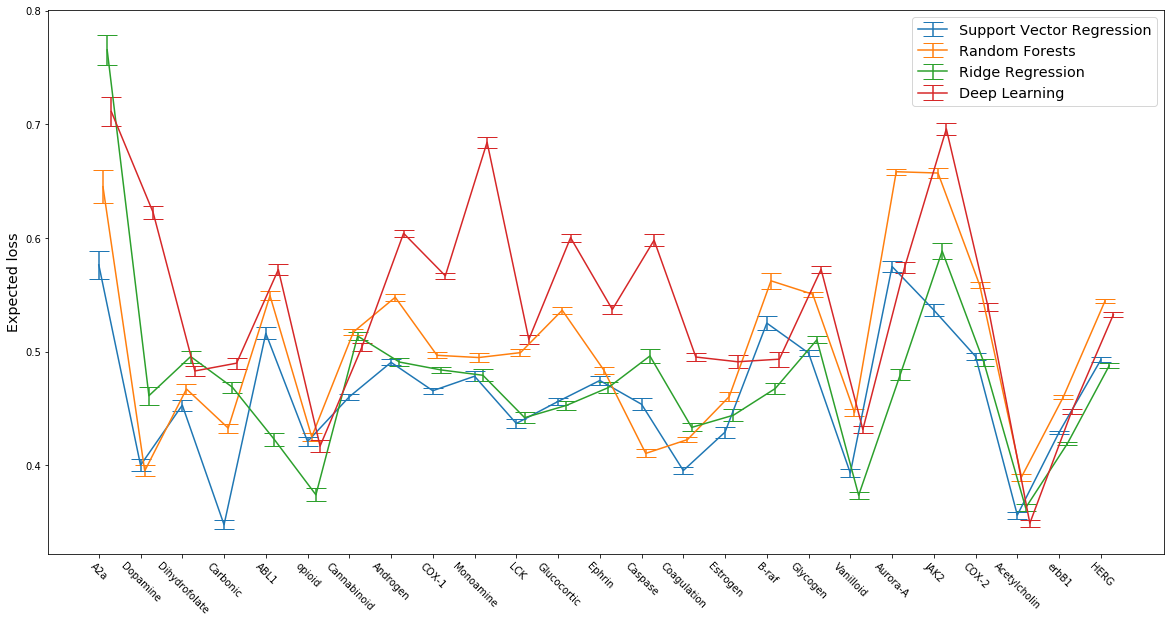

In [40]:
# Training set activity thresholded at q=0.6, scored by active-rank average loss, gamma = 0.9
plotter(frac_fit=0.6, loss='loss_avg_90')

figures_dl/loss_06_loss_min_90.pdf


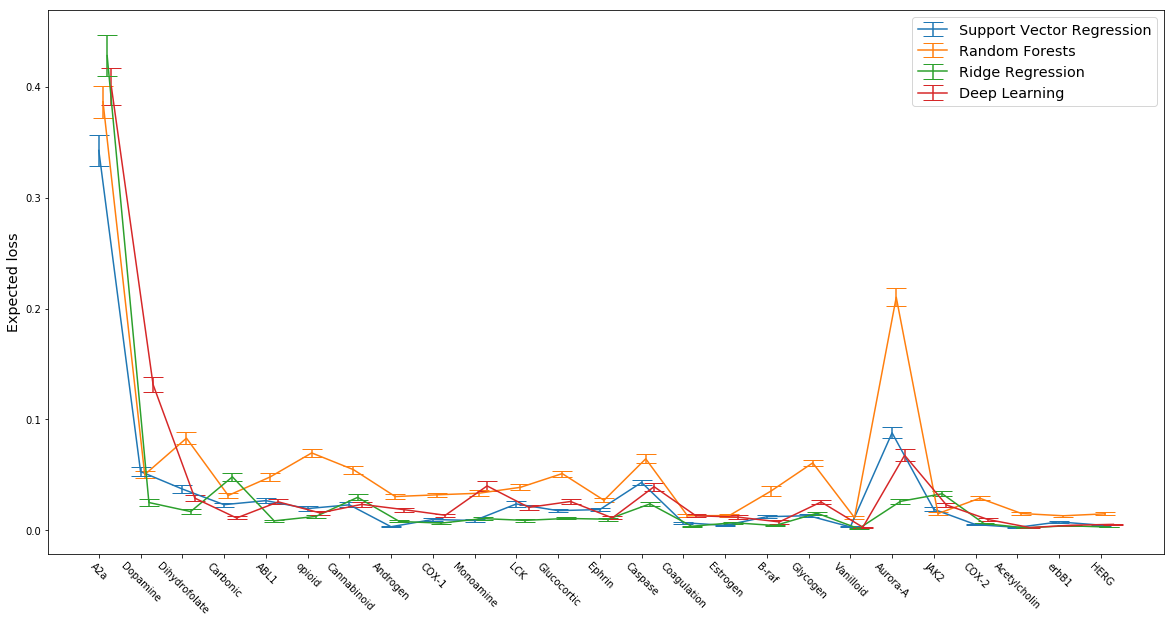

In [41]:
# Training set activity thresholded at q=0.6, scored by active-rank min loss, gamma = 0.9
plotter(frac_fit=0.6, loss='loss_min_90')

### Out-of-sample loss plots ( training on thresholded data: q=0.4 )

figures_dl/loss_04_mse.pdf


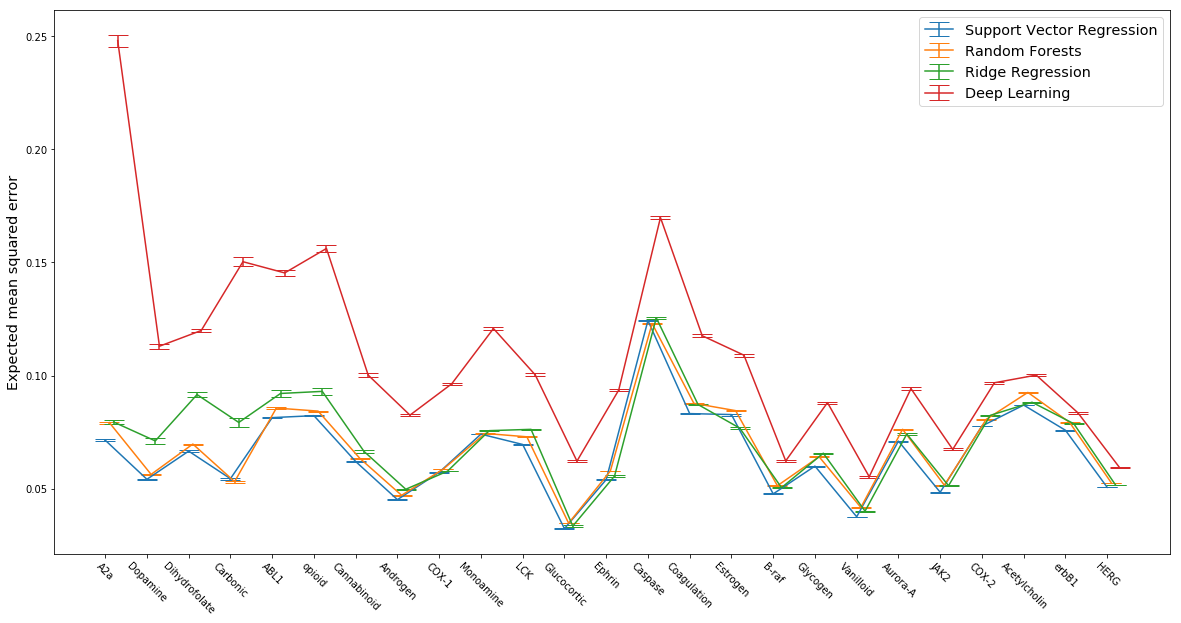

In [42]:
# Training set activity thresholded at q=0.4, scored by MSE
plotter(frac_fit=0.4)

figures_dl/loss_04_loss_avg_99.pdf


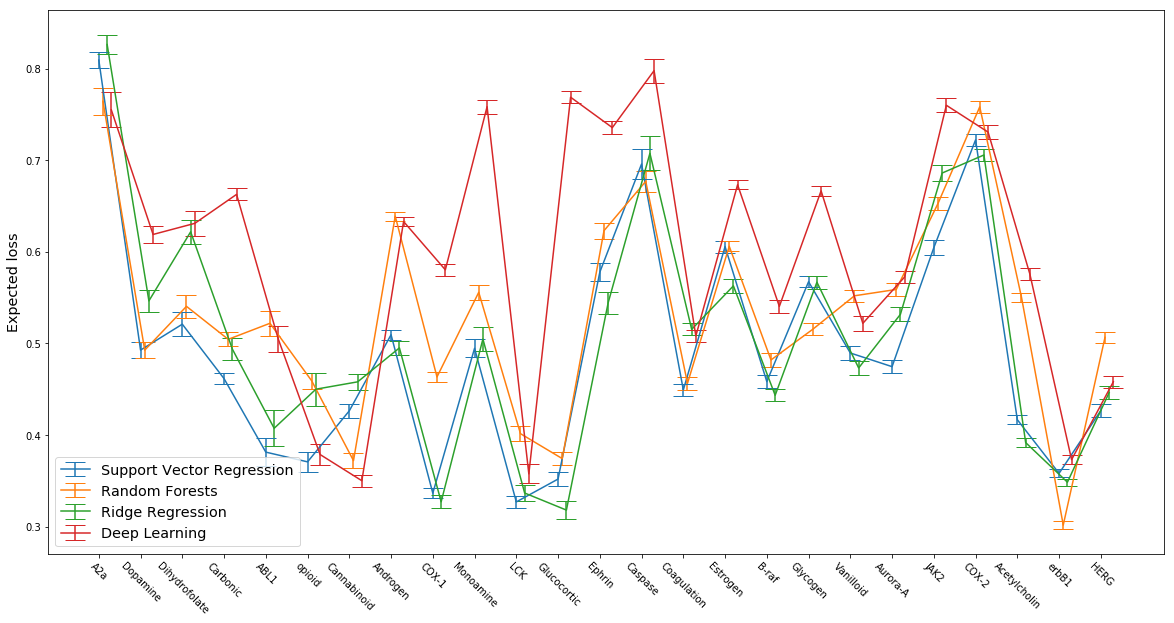

In [43]:
# Training set activity thresholded at q=0.4, scored by active-rank average loss, gamma = 0.9
plotter(frac_fit=0.4, loss='loss_avg_99')

figures_dl/loss_04_loss_min_90.pdf


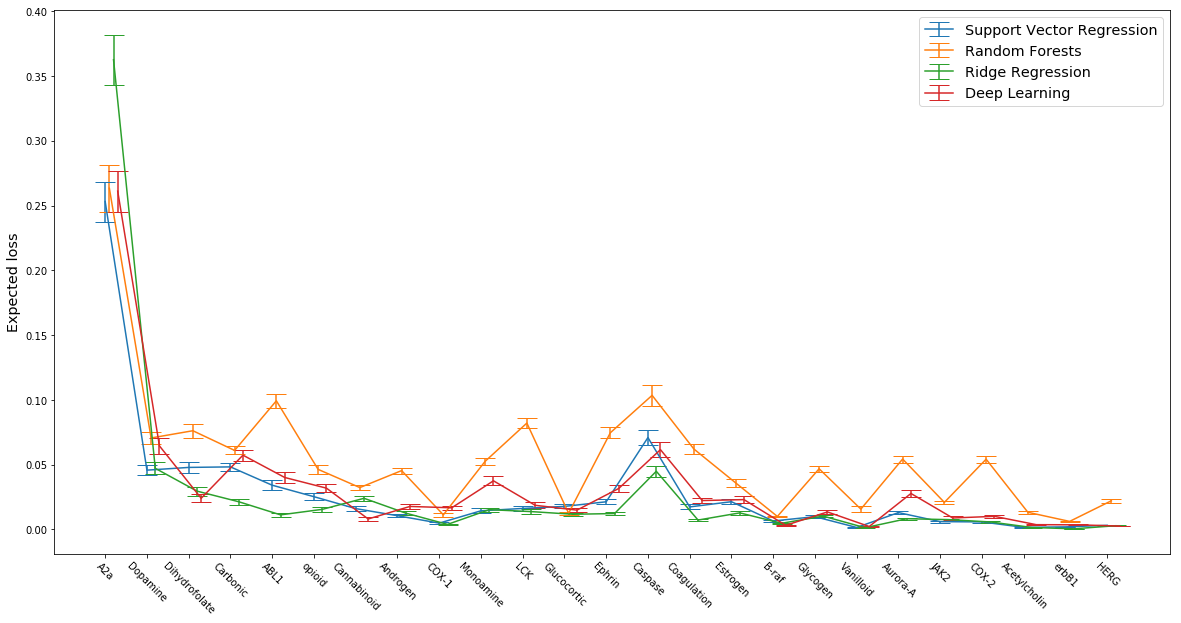

In [44]:
# Training set activity thresholded at q=0.4, scored by active-rank min loss, gamma = 0.9
plotter(frac_fit=0.4, loss='loss_min_90')

figures_dl/loss_04_loss_min_99.pdf


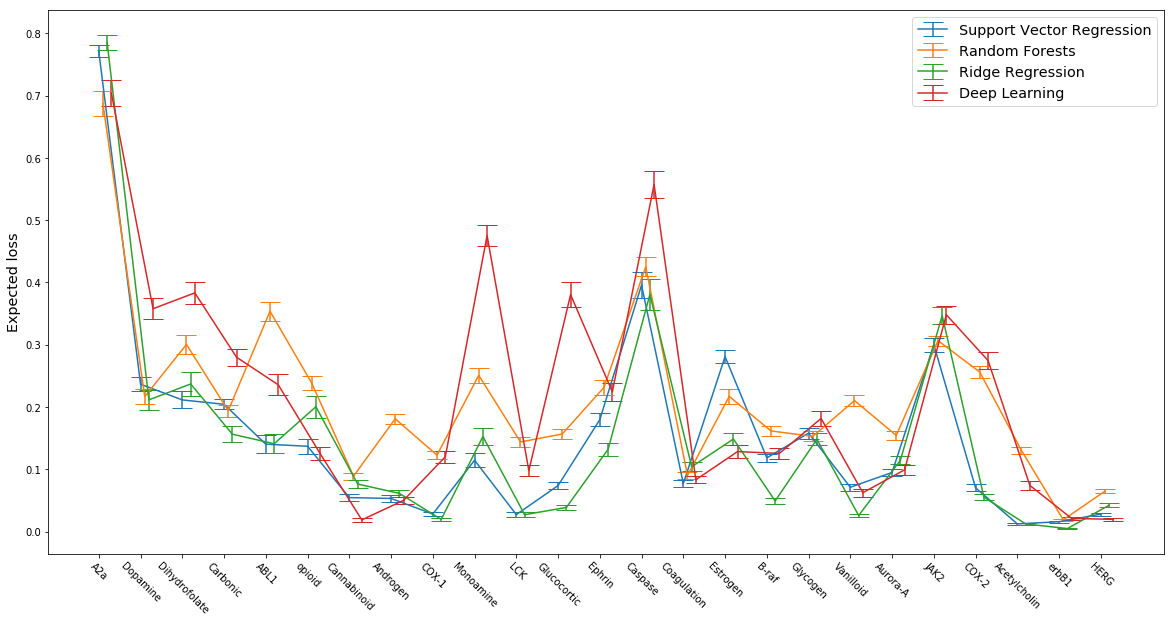

In [45]:
# Training set activity thresholded at q=0.4, scored by active-rank min loss, gamma = 0.99
plotter(frac_fit=0.4, loss='loss_min_99')

## Overall Results

In [46]:
def probability_min(means, sigmas, K=1000, epsilon = 0.01):
    
    N = len(means)
    probs = np.zeros(N) # array of probability weights
    
    # check that none of the sigmas are zero to avoid NANs
    for ss in range(N):
        if(sigmas[ss]==0):
            sigmas[ss] = epsilon
            pass
        pass

    for i in range(N):
        xs = np.random.normal(loc=means[i],scale=sigmas[i],size=K)
        logterms = np.zeros(K)
        # Iterate over random draw from the i^th normal distribution
        for sim in range(K):
            x = xs[sim]
            logproductterm = 0
            for j in range(N):
                if(j != i):
                    logproductterm += stats.norm.logcdf(-(x-means[j])/sigmas[j]) 
                    pass
                pass
            logterms[sim] = logproductterm
            pass
        probs[i] = np.mean(np.exp(logterms))
        pass
    return probs

# Total score : this is change of ll_estimate
def model_score(frac_fit=1.0, losses=['loss_avg_90', 'mse', ], kf=0, K=1000, recompute_scores=False):
    if recompute_scores:
        fnf = get_fn(frac_fit, kf=0)
        loss_hdr = joblib.load(fnf)

        print(('%9s |' + '%12s |' * len(losses)) % tuple(['',] + losses))
        print('-' * (11 * (len(losses) + 1) - 1))

        M = len(model_dict.keys()) # number of models

        Loss_scores = []

        models = model_dict.keys()
        d = {'losses' : [x + '_' + str(frac_fit) for x in losses]}

        for loss in losses:
            scores = np.zeros(M)
            for tgt in sorted_targets:
                tgt_means = []
                tgt_sigmas = []
                # For each model we extract the mean and SD
                for (i, method) in enumerate(models):
                    lmean = loss_hdr[tgt][method][loss]['loss']
                    llow = loss_hdr[tgt][method][loss]['loss_l']
                    lsigma = (lmean - llow)/2
                    tgt_means.append(lmean)
                    tgt_sigmas.append(lsigma)
                    pass
                # The arrays of means and SDs are used to compute probability of min expected loss
                weights = probability_min(tgt_means, tgt_sigmas, K=K)
                # A weight of 1: min loss with probability 1; weight of 0: min loss with probability 0

                scores += weights   
                pass
            Loss_scores.append(scores)



        for (i, method) in enumerate(models):
            d[method] = np.asarray([x[i] for x in Loss_scores])
            out = [method,]
            for (j, loss) in enumerate(losses):
                out.append(Loss_scores[j][i])
                pass
            print (('%9s |' + '%12.1f |' * len(losses)) % tuple(out))

        return d
    else:
        print('done this already, skipping...')

In [47]:
b = [1, 2, 3]
c = dict((a, 1) for a in b)

In [48]:
c

{1: 1, 2: 1, 3: 1}

In [49]:
list(loss_dict.keys())

['loss_min_99',
 'loss_min_90',
 'loss_min_95',
 'loss_avg_99',
 'mse',
 'loss_avg_95',
 'loss_avg_90']

In [50]:
%pdb on

Automatic pdb calling has been turned ON


In [51]:
# Change this when the models are rerun
recompute_scores = True

d_oos = model_score(losses=list(loss_dict.keys()), recompute_scores=recompute_scores)

          | loss_min_99 | loss_min_90 | loss_min_95 | loss_avg_99 |         mse | loss_avg_95 | loss_avg_90 |
---------------------------------------------------------------------------------------
      svr |         2.2 |         3.7 |         1.7 |         0.7 |         0.0 |         1.9 |         0.4 |
       rf |        11.8 |        13.4 |        17.1 |        10.6 |        24.0 |        12.5 |        17.2 |
    ridge |         0.0 |         0.4 |         0.5 |         1.5 |         0.0 |         0.1 |         0.0 |
     dl_l |        11.0 |         7.5 |         5.8 |        12.1 |         1.0 |        10.5 |         7.4 |


In [52]:
d_oos

{'dl_l': array([ 11.0024504 ,   7.5140067 ,   5.76056342,  12.14096112,
          0.9976415 ,  10.46066475,   7.44505897]),
 'losses': ['loss_min_99_1.0',
  'loss_min_90_1.0',
  'loss_min_95_1.0',
  'loss_avg_99_1.0',
  'mse_1.0',
  'loss_avg_95_1.0',
  'loss_avg_90_1.0'],
 'rf': array([ 11.81664794,  13.43351312,  17.05428607,  10.59005982,
         24.00192615,  12.481277  ,  17.16776244]),
 'ridge': array([  8.96552535e-03,   3.98477402e-01,   4.98388834e-01,
          1.50917868e+00,   0.00000000e+00,   1.21674411e-01,
          1.71333839e-12]),
 'svr': array([  2.15957696e+00,   3.66003550e+00,   1.71209021e+00,
          7.35109804e-01,   7.17472356e-11,   1.91958433e+00,
          4.13032978e-01])}

In [53]:
import pandas as pd

In [54]:
d_09 = model_score(losses=list(loss_dict.keys()), frac_fit=0.9, recompute_scores=recompute_scores)

          | loss_min_99 | loss_min_90 | loss_min_95 | loss_avg_99 |         mse | loss_avg_95 | loss_avg_90 |
---------------------------------------------------------------------------------------
      svr |         5.3 |         1.3 |         3.3 |         8.8 |         1.3 |         9.3 |        12.0 |
       rf |         5.1 |         4.1 |         3.7 |         4.5 |        18.7 |         9.5 |         6.5 |
    ridge |         7.3 |         8.9 |         6.0 |         2.2 |         0.0 |         2.0 |         1.0 |
     dl_l |         7.4 |        10.6 |        12.0 |         9.5 |         5.0 |         4.2 |         5.5 |


In [55]:
d_08 = model_score(losses=list(loss_dict.keys()), frac_fit=0.8, recompute_scores=recompute_scores)

          | loss_min_99 | loss_min_90 | loss_min_95 | loss_avg_99 |         mse | loss_avg_95 | loss_avg_90 |
---------------------------------------------------------------------------------------
      svr |         5.1 |         3.9 |         6.0 |         8.4 |         8.8 |        11.6 |        13.1 |
       rf |         5.0 |         1.0 |         3.0 |         4.8 |        12.5 |         6.1 |         4.9 |
    ridge |        10.0 |        12.0 |        10.5 |         6.9 |         0.0 |         3.3 |         4.0 |
     dl_l |         4.9 |         8.1 |         5.6 |         4.8 |         3.7 |         4.0 |         3.0 |


In [56]:
d_06 = model_score(losses=list(loss_dict.keys()), frac_fit=0.6, recompute_scores=recompute_scores)

          | loss_min_99 | loss_min_90 | loss_min_95 | loss_avg_99 |         mse | loss_avg_95 | loss_avg_90 |
---------------------------------------------------------------------------------------
      svr |         7.1 |         6.6 |         7.0 |         8.0 |        17.1 |        12.5 |        11.3 |
       rf |         2.0 |         1.0 |         1.0 |         3.8 |         3.0 |         1.8 |         1.9 |
    ridge |        11.9 |        15.8 |        15.6 |        10.3 |         3.8 |        10.0 |        10.8 |
     dl_l |         4.0 |         1.6 |         1.4 |         3.0 |         1.0 |         0.7 |         1.0 |


In [57]:
d_04 = model_score(losses=list(loss_dict.keys()), frac_fit=0.4, recompute_scores=recompute_scores)

          | loss_min_99 | loss_min_90 | loss_min_95 | loss_avg_99 |         mse | loss_avg_95 | loss_avg_90 |
---------------------------------------------------------------------------------------
      svr |         6.5 |         5.6 |         3.1 |        10.1 |        22.0 |         9.6 |        12.4 |
       rf |         1.6 |         0.3 |         0.0 |         3.8 |         2.0 |         2.8 |         0.3 |
    ridge |        11.8 |        15.0 |        17.7 |         9.1 |         1.0 |         9.6 |        10.2 |
     dl_l |         5.1 |         4.0 |         4.2 |         1.9 |         0.0 |         3.0 |         2.1 |


In [58]:
pd.DataFrame.from_dict(d_oos)

,dl_l,losses,rf,ridge,svr
0,11.002450,loss_min_99_1.0,11.816648,8.965525e-03,2.159577e+00
1,7.514007,loss_min_90_1.0,13.433513,3.984774e-01,3.660035e+00
2,5.760563,loss_min_95_1.0,17.054286,4.983888e-01,1.712090e+00
3,12.140961,loss_avg_99_1.0,10.590060,1.509179e+00,7.351098e-01
4,0.997642,mse_1.0,24.001926,0.000000e+00,7.174724e-11
5,10.460665,loss_avg_95_1.0,12.481277,1.216744e-01,1.919584e+00
6,7.445059,loss_avg_90_1.0,17.167762,1.713338e-12,4.130330e-01


In [59]:
if recompute_scores:
    pd0 = pd.DataFrame(d_oos)
    for d in (d_09, d_08, d_06, d_04):
        pdd = pd.DataFrame(d)
        pd0 = pd0.append(pdd, ignore_index=True)
        pass
    pd0
    if do_dl:
        pd0.to_csv('models_final_dl/loss_summary.csv')
    else:
        pd0.to_csv('models_final/loss_summary.csv')